In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [32]:
train_path = "/kaggle/input/african/Train.csv"
test_path = "/kaggle/input/african/Test.csv"
macro_path = "/kaggle/input/economic/economic_indicators.csv"

In [33]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [34]:
def preprocess_data():
    data = pd.concat([train, test]).reset_index(drop=True)

    data['disbursement_date'] = pd.to_datetime(data['disbursement_date'], errors='coerce')
    data['due_date'] = pd.to_datetime(data['due_date'], errors='coerce')
    
    date_cols = ['disbursement_date', 'due_date']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data[col+'_month'] = data[col].dt.month
        data[col+'_day'] = data[col].dt.day
        data[col+'_year'] = data[col].dt.year
        data[f'loan_term_days'] = (data['due_date'] - data['disbursement_date']).dt.days
        data[f'disbursement_weekday'] = data['disbursement_date'].dt.weekday
        data[f'due_weekday'] = data['due_date'].dt.weekday
    
    data['repayment_ratio'] = data['Total_Amount_to_Repay'] / data['Total_Amount']
    data['log_Total_Amount'] = np.log1p(data['Total_Amount'])
    data['interest_rate'] = (data['Total_Amount_to_Repay'] - data['Total_Amount']) / data['Total_Amount'] * 100
    
    cat_cols = data.select_dtypes(include='object').columns
    data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
    loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
    data[loan_type_cols] = data[loan_type_cols].astype(int)
    
    le = LabelEncoder()
    for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
        data[col] = le.fit_transform(data[col])
    
    train_df = data[data['ID'].isin(train['ID'].unique())]
    test_df = data[data['ID'].isin(test['ID'].unique())]
    
    features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

    return train_df, test_df, features_for_modelling

In [35]:
def predict_with_threshold(model, X, threshold=0.3):
    y_pred_proba = model.predict(X)
    return (y_pred_proba > threshold).astype(int)

In [56]:
def create_model(input_dim):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        layers.BatchNormalization(),
        
        # First layer with strong regularization
        layers.Dense(64, 
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Second layer
        layers.Dense(32,
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_model(X_train, y_train, X_val, y_val, features_for_modelling):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Convert to numpy arrays if they aren't already
    X_train_scaled = np.array(X_train_scaled)
    y_train = np.array(y_train)
    X_val_scaled = np.array(X_val_scaled)
    y_val = np.array(y_val)
    
    # Hardcode class weights
    class_weights = {
        0: 0.5,  # majority class
        1: 27.0  # minority class
    }
    
    print("Using class weights:", class_weights)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc', curve='ROC'),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True,
        min_delta=0.001
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        mode='max',
        verbose=1
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, scaler, history

In [37]:
train_df, test_df, features_for_modelling = preprocess_data()

X_train, X_val, y_train, y_val = train_test_split(
    train_df[features_for_modelling], 
    train_df['target'], 
    random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(51490, 46) (17164, 46) (51490,) (17164,)


In [57]:
model, scaler, history = train_model(X_train, y_train, X_val, y_val, features_for_modelling)

Using class weights: {0: 0.5, 1: 27.0}
Epoch 1/100
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9664 - auc: 0.9930 - loss: 0.0843 - precision_9: 0.3464 - recall_9: 0.9722 - val_accuracy: 0.9836 - val_auc: 0.9761 - val_loss: 0.0826 - val_precision_9: 0.5207 - val_recall_9: 0.8344 - learning_rate: 1.0000e-04
Epoch 2/100
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9582 - auc: 0.9909 - loss: 0.1042 - precision_9: 0.3054 - recall_9: 0.9643 - val_accuracy: 0.9821 - val_auc: 0.9804 - val_loss: 0.1001 - val_precision_9: 0.4952 - val_recall_9: 0.8510 - learning_rate: 1.0000e-04
Epoch 3/100
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9580 - auc: 0.9928 - loss: 0.0894 - precision_9: 0.3057 - recall_9: 0.9820 - val_accuracy: 0.9801 - val_auc: 0.9784 - val_loss: 0.0728 - val_precision_9: 0.4656 - val_recall_9: 0.8742 - learning_rate: 1.0000e-04
Epoch 4/100
1610/1610 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9542 - auc: 0.9907 - loss: 0.1114 - precision_9:

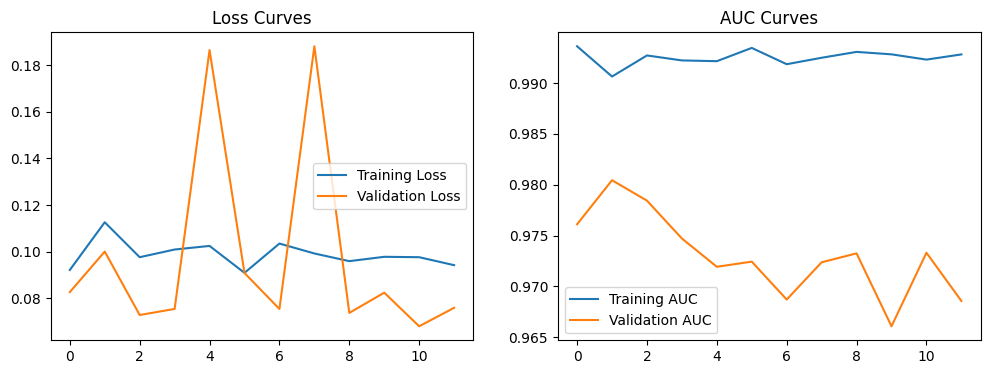

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.title('AUC Curves')
plt.show()

In [62]:
def make_predictions(model, scaler, test_data, features_for_modelling, threshold=0.3):
    X_test_scaled = scaler.transform(test_data[features_for_modelling])
    
    raw_predictions = model.predict(X_test_scaled)
    
    print("\nRaw prediction distribution:")
    print(np.histogram(raw_predictions, bins=10))
    
    binary_predictions = (raw_predictions > threshold).astype(int)
    
    print("\nBinary prediction distribution:")
    print(np.bincount(binary_predictions.ravel()))
    
    output = pd.DataFrame({
        'ID': test_data['ID'],
        'target': binary_predictions.ravel()
    })
    
    return output

In [65]:
train_df, test_df, features_for_modelling = preprocess_data()
output = make_predictions(model, scaler, test_df, features_for_modelling)

                          ID  customer_id  country_id  tbl_loan_id  lender_id  \
68654  ID_269404226088267278       269404           1       226088     267278   
68655  ID_255356300042267278       255356           1       300042     267278   
68656  ID_257026243764267278       257026           1       243764     267278   
68657  ID_264617299409267278       264617           1       299409     267278   
68658  ID_247613296713267278       247613           1       296713     267278   
...                      ...          ...         ...          ...        ...   
87243  ID_297596365331297183       297596           0       365331     297183   
87244  ID_259715231897267278       259715           1       231897     267278   
87245  ID_296701364008297183       296701           0       364008     297183   
87246  ID_268271242864267278       268271           1       242864     267278   
87247  ID_248929241821267278       248929           1       241821     267278   

       Total_Amount  Total_

In [67]:
output.to_csv('Test_predictions.csv', index=False)
print("Predictions saved to Test_predictions.csv")

Predictions saved to Test_predictions.csv
